In [7]:
import copy as cp
import itertools as itt
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
import pickle
import scipy.optimize as spo
import scipy.special as spsp
import scipy.stats as sps
import seaborn as sns

from matplotlib.ticker import FixedLocator

mpl.rcParams['axes.titlesize'] = 'xx-large'
mpl.rcParams['axes.labelsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.fontsize'] = 'large'

path_proj = os.path.dirname(os.getcwd()) + '/M_HSC/'
path_sc = path_proj + 'csv/Single_cell/'
path_sort = path_proj + 'csv/Sort/'
path_plot = path_proj + 'figures/'
print(path_proj)

/Users/quanti/Desktop/M_HSC/


In [2]:
#LOAD THE PROCESSED DATA
df = pd.read_csv(path_sc+'Pooled_data.csv', sep=';', decimal=',')
dfi = pd.read_csv(path_sort+'Pooled_data.csv', sep=';', decimal=',')

In [3]:
def dot_plot_phenotyped(df):
    
    #SET FIGURE WIDTH AND HEIGHT
    families = np.unique(df.Family)
    n_gens = int(max(df.Generation)) + 1
    max_cells_per_g = np.array([
        max([np.logical_and(df.Family==c, df.Generation==g).sum() for c in families])
        for g in np.arange(0, n_gens)
    ])
    max_cells_per_g[max_cells_per_g==0] = np.ones((max_cells_per_g==0).sum())
    width = sum(max_cells_per_g)/12.
    height = len(families)/14.
    
    #SET MAJOR AND MINOR AXES LOCATORS
    xmin = 0.5
    xmax = sum(max_cells_per_g)+0.75    
    y_minorLocator = FixedLocator(np.arange(len(families))[1:]+0.5)
    min_loc = xmin + np.cumsum(max_cells_per_g)
    maj_loc = np.hstack((xmin,min_loc))
    maj_loc = np.array([(maj_loc[i]+maj_loc[i+1])/2. for i in range(len(maj_loc)-1)])
    minorLocator = FixedLocator(min_loc)
    majorLocator = FixedLocator(maj_loc)
    
    #SORT FAMILIES
    #BY TOTAL RANK
    families = sorted(families, key=lambda x: df[df.Family==x].Cell_rank.sum(), reverse=False)
    #BY FAMILY SIZE
    families = sorted(families, key=lambda x: len(df[df.Family==x]), reverse=False)
    #BY MINIMUM GENERATION
    families = sorted(families, key=lambda x: min(df[df.Family==x].Generation), reverse=False)
    #BY GENERATIONAL RANGE (MAX-MIN FAMILY GENERATION)
    families = sorted(families, key=lambda x: max(df[df.Family==x].Generation)-
                                 min(df[df.Family==x].Generation), reverse=False)

    x_gen = np.hstack((0,np.cumsum(max_cells_per_g)[:-1]))+1.

    x_cell = np.hstack([
        x_gen[g] + np.arange(len(df[(df.Family==fam)&(df.Generation==g)]))
        for k,fam in enumerate(families) for g in np.unique(df[df.Family==fam].Generation)
    ])
    y_cell = np.hstack([
        np.array([len(families) - k for i in range(len(df[(df.Family==fam)&(df.Generation==g)]))])
        for k,fam in enumerate(families) for g in np.unique(df[df.Family==fam].Generation)
    ])
    col_cell = np.hstack([
        df[(df.Family==fam)&(df.Generation==g)].sort_values(by=['Cell_rank']).Cell_color.values
        for k,fam in enumerate(families) for g in np.unique(df[df.Family==fam].Generation)
    ])

    fig, ax = plt.subplots(figsize=(width, height + 1.))
    with sns.axes_style("ticks"):
        #PLOT DOTS
        ax.scatter(x=x_cell, y=y_cell, s=9,
                   c=col_cell, edgecolor=col_cell, marker=u's')
        #PUT VERTICAL LINE TO SEPARATE RANGE
        fams_gen_range = [max(df[df.Family==fam].Generation) - min(df[df.Family==fam].Generation)
                          for fam in families]
        for k in range(len(fams_gen_range)-1):
            if fams_gen_range[k] != fams_gen_range[k+1]:
                ax.hlines(len(families) - k - 0.5, xmin=xmin, xmax=xmax,
                          colors=u'DarkGrey', linestyles=u'-', lw=0.5)
                ax.text(xmax+0.2, len(families) - k - 0.2,
                        str(int(fams_gen_range[k])), fontsize='xx-small')
        ax.text(xmax+0.2, 0.7, str(int(fams_gen_range[-1])), fontsize='xx-small')
                
    #MORE PLOTTING PARAMETERS
    ax.xaxis.set_minor_locator(minorLocator)
    ax.xaxis.set_major_locator(majorLocator)
    ax.yaxis.set_minor_locator(y_minorLocator)    
    ax.tick_params(axis='x', pad=0)
    ax.set_axisbelow(True)
    ax.grid(which=u'minor', axis='y', color='DarkGrey', linestyle=':', linewidth=0.5)
    ax.grid(which=u'minor', axis=u'x', color='DarkGrey', linestyle='-', linewidth=0.5)
    
    #HASHTAGS FOR FULL FAMILIES
    lst_fam_vec = [np.unique(df[df.Family==fam].Generation, return_counts=True) for fam in families]
    cohort_number = np.array([(el[1]/np.power(2.,el[0])).sum() for el in lst_fam_vec])
    y_ticks_label = ['#' + str(k+1) if cn==1 else str(k+1) for k,cn in enumerate(cohort_number)]
    y_ticks_loc = np.arange(len(families), 0, -1)
    ax.set_yticks(y_ticks_loc)
    ax.set_yticklabels(y_ticks_label, fontsize='xx-small', ha='right')
    
    #AESTHETIC PARAMETERS
    ax.set_xticks(maj_loc)
    ax.set_xticklabels(range(0,int(max(df.Generation))+1), fontsize='small')
    ax.tick_params(pad=1)
    ax.set_xlabel('Generation')
    ax.set_ylabel('Clonal Family')
    ax.set_ylim(0.25, 1+len(families)-0.25)
    ax.set_xlim(left=xmin, right=xmax)
    for tic in ax.xaxis.get_major_ticks():
        tic.tick1On = True
        tic.tick2On = False
    for tic in ax.xaxis.get_minor_ticks():
        tic.tick1On = False
        tic.tick2On = False
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1On = True
        tic.tick2On = False
    for tic in ax.yaxis.get_minor_ticks():
        tic.tick1On = False
        tic.tick2On = False
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(2.)
    return fig, ax

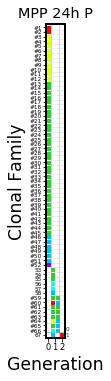

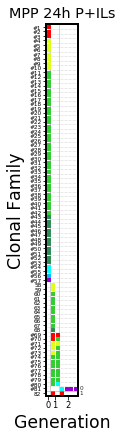

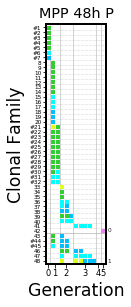

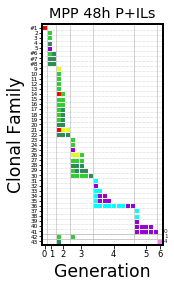

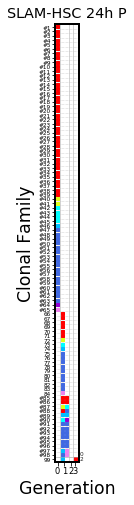

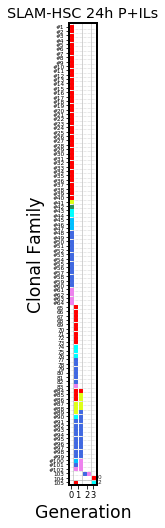

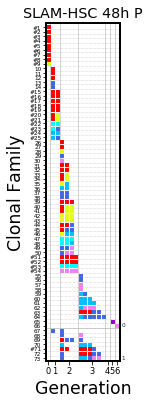

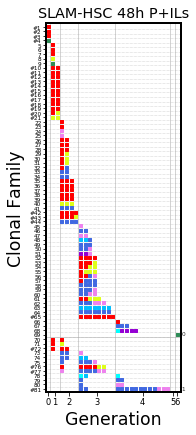

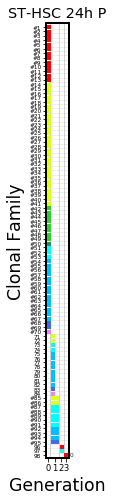

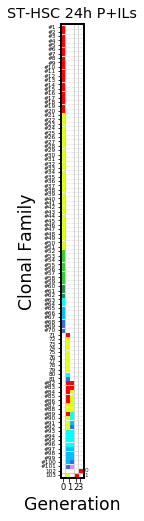

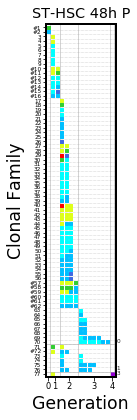

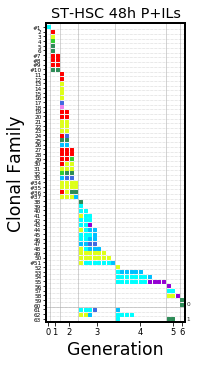

In [8]:
lst_oc_t_cnd = [(oc,t,cnd) for oc in np.unique(df.Original_cell)
                   for t in np.unique(df.Culture_time)
                   for cnd in np.unique(df.Culture_condition)]
for oc,t,cnd in lst_oc_t_cnd:
    df_temp = df[(df.Original_cell==oc)&(df.Culture_time==t)&(df.Culture_condition==cnd)]
    fig,ax = dot_plot_phenotyped(df=df_temp)
    ax.set_title(oc+' '+t+' '+cnd, fontsize='x-large')
    fig.savefig(path_plot+'Dotplot '+oc+' '+t+' '+cnd+'.pdf', bbox_inches='tight')